In [ ]:
#import necessary libraries
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


In [ ]:
#Defining data path and dataset name
train_data_dir = '/Users/unnathi/Downloads/Master Folder/train'
valid_data_dir = '/Users/unnathi/Downloads/Master Folder/valid'
test_data_dir = '/Users/unnathi/Downloads/Master Folder/test'

data_dir = '/kaggle/input/pets-facial-expression-dataset'


ds_name = 'Pets Facial Expression'

In [ ]:
# Generate data paths with labels

def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        if fold == 'Master Folder':
            continue

        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [ ]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [ ]:
df.head()

,filepaths,labels
0,/kaggle/input/pets-facial-expression-dataset/O...,Other
1,/kaggle/input/pets-facial-expression-dataset/O...,Other
2,/kaggle/input/pets-facial-expression-dataset/O...,Other
3,/kaggle/input/pets-facial-expression-dataset/O...,Other
4,/kaggle/input/pets-facial-expression-dataset/O...,Other


In [ ]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

The Pets Facial Expression dataset has 1000 images.


In [ ]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")

num_of_classes(df, ds_name)

The Pets Facial Expression dataset has 4 classes


Display count of images in each class of the dataset

In [ ]:
def classes_count(df, name='df'):

    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)

classes_count(df, ds_name)

The Pets Facial Expression dataset has: 

Class 'Other' has 250 images
----------------------------------------------------------------------
Class 'Angry' has 250 images
----------------------------------------------------------------------
Class 'Sad' has 250 images
----------------------------------------------------------------------
Class 'happy' has 250 images
----------------------------------------------------------------------


In [ ]:
#check for the null values and eliminate them
def check_null_values(df, name='df'):

    num_null_vals = sum(df.isnull().sum().values)

    if not num_null_vals:
        print(f"The {name} dataset has no null values")

    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())


check_null_values(df, ds_name)

The Pets Facial Expression dataset has no null values


In [ ]:
#splitting into test and training data sets

# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
num_of_examples(train_df, "Training "+ds_name)
num_of_examples(valid_df, "Validation "+ds_name)
num_of_examples(test_df, "Testing "+ds_name)

The Training Pets Facial Expression dataset has 800 images.
The Validation Pets Facial Expression dataset has 120 images.
The Testing Pets Facial Expression dataset has 80 images.


In [ ]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Pets Facial Expression dataset has 4 classes
The Validation Pets Facial Expression dataset has 4 classes
The Testing Pets Facial Expression dataset has 4 classes


In [ ]:
classes_count(train_df, 'Training '+ds_name)

The Training Pets Facial Expression dataset has: 

Class 'Sad' has 209 images
----------------------------------------------------------------------
Class 'happy' has 192 images
----------------------------------------------------------------------
Class 'Angry' has 201 images
----------------------------------------------------------------------
Class 'Other' has 198 images
----------------------------------------------------------------------


In [ ]:
classes_count(valid_df, 'Validation '+ds_name)

The Validation Pets Facial Expression dataset has: 

Class 'Angry' has 29 images
----------------------------------------------------------------------
Class 'Sad' has 28 images
----------------------------------------------------------------------
Class 'Other' has 35 images
----------------------------------------------------------------------
Class 'happy' has 28 images
----------------------------------------------------------------------


In [ ]:
classes_count(test_df, 'Testing '+ds_name)

The Testing Pets Facial Expression dataset has: 

Class 'Other' has 17 images
----------------------------------------------------------------------
Class 'Angry' has 20 images
----------------------------------------------------------------------
Class 'happy' has 30 images
----------------------------------------------------------------------
Class 'Sad' has 13 images
----------------------------------------------------------------------


In [ ]:
#Create image data generator

# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 800 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 80 validated image filenames belonging to 4 classes.


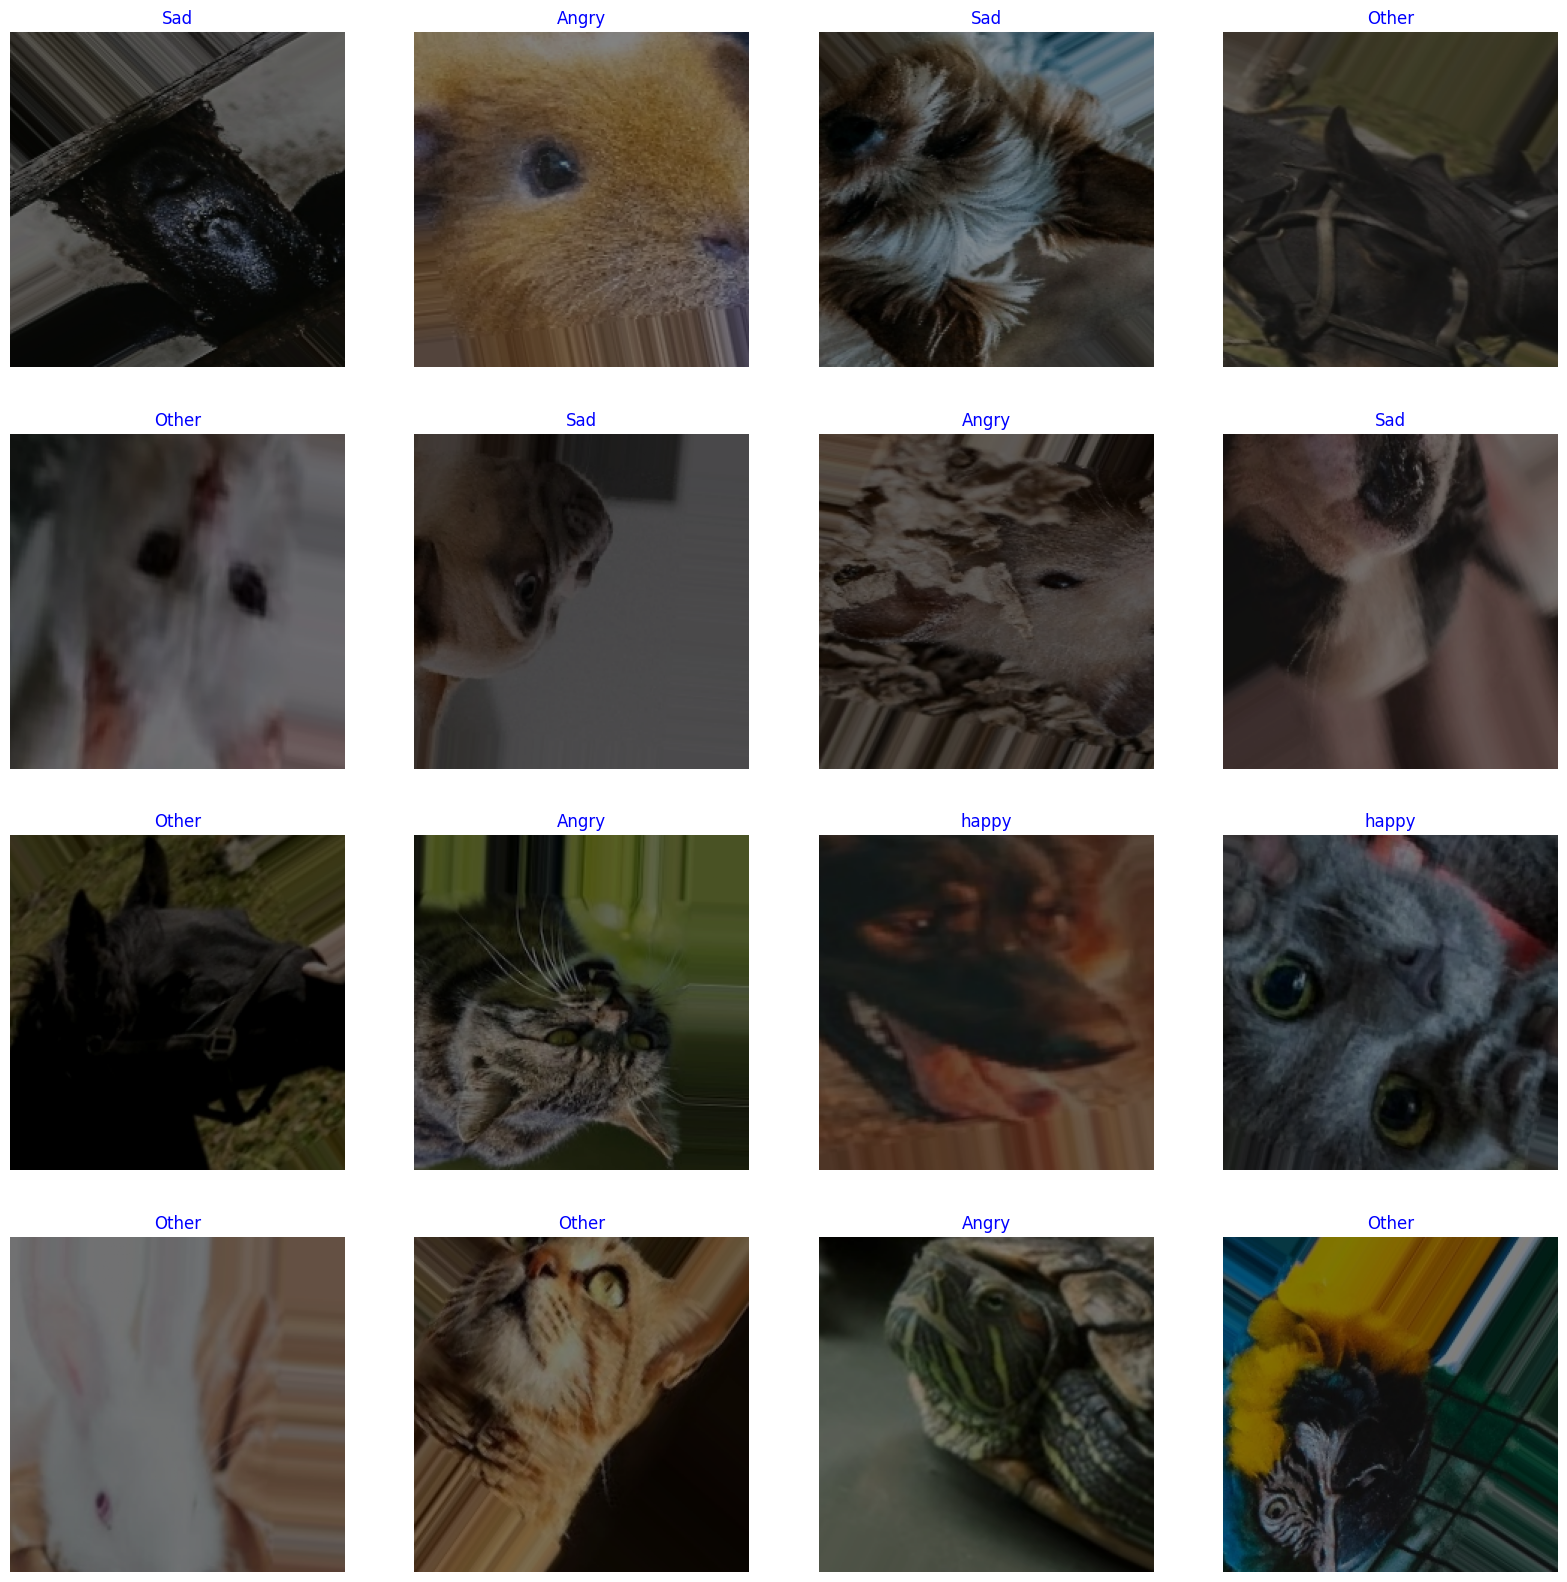

In [ ]:
#Visualise the training data set
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')

plt.show()

In [ ]:
#model creation

# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, activation='relu'),
    Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.summary()

115263384/115263384 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 

'mixed7' as the last layer of your base model

In [ ]:
#Compile the model
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
#Train the model
batch_size = 16   # set batch size for training
history = model.fit(x=train_gen,
                    epochs= 100,
                    verbose= 1,
                    validation_data= valid_gen,
                    validation_steps= None,
                    shuffle= False)

Epoch 1/100


2023-09-25 16:26:42.595464: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


50/50 [==============================] - 47s 490ms/step - loss: 4.7665 - accuracy: 0.3313 - val_loss: 4.5941 - val_accuracy: 0.4250
Epoch 2/100
50/50 [==============================] - 14s 273ms/step - loss: 4.4451 - accuracy: 0.3988 - val_loss: 4.1801 - val_accuracy: 0.5000
Epoch 3/100
50/50 [==============================] - 14s 288ms/step - loss: 4.1925 - accuracy: 0.4412 - val_loss: 4.0485 - val_accuracy: 0.4833
Epoch 4/100
50/50 [==============================] - 14s 276ms/step - loss: 4.0196 - accuracy: 0.4750 - val_loss: 3.8006 - val_accuracy: 0.5250
Epoch 5/100
50/50 [==============================] - 15s 293ms/step - loss: 3.8127 - accuracy: 0.5025 - val_loss: 3.6331 - val_accuracy: 0.6083
Epoch 6/100
50/50 [==============================] - 14s 274ms/step - loss: 3.7432 - accuracy: 0.5088 - val_loss: 3.5471 - val_accuracy: 0.6333
Epoch 7/100
50/50 [==============================] - 14s 279ms/step - loss: 3.5547 - accuracy: 0.5688 - val_loss: 3.4626 - val_accuracy: 0.6333
Epoc

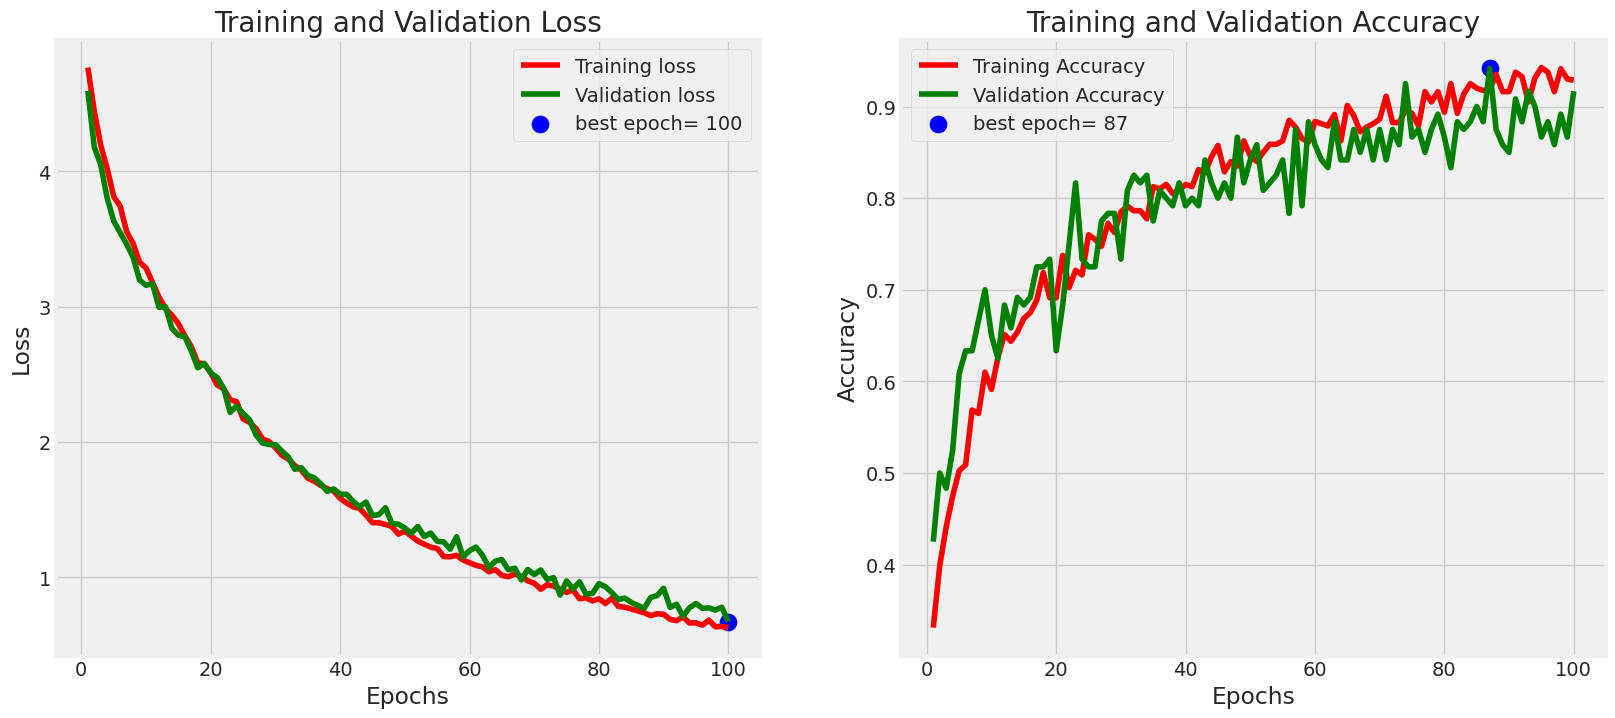

In [ ]:
#Evaluationg the model based on loss and accuracy

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
#model accuracy
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 [==============================] - 3s 3s/step - loss: 0.6816 - accuracy: 0.8875
Train Loss:  0.4364301562309265
Train Accuracy:  1.0
--------------------
Test Loss:  0.6815977096557617
Test Accuracy:  0.887499988079071


In [ ]:
#get prediction
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

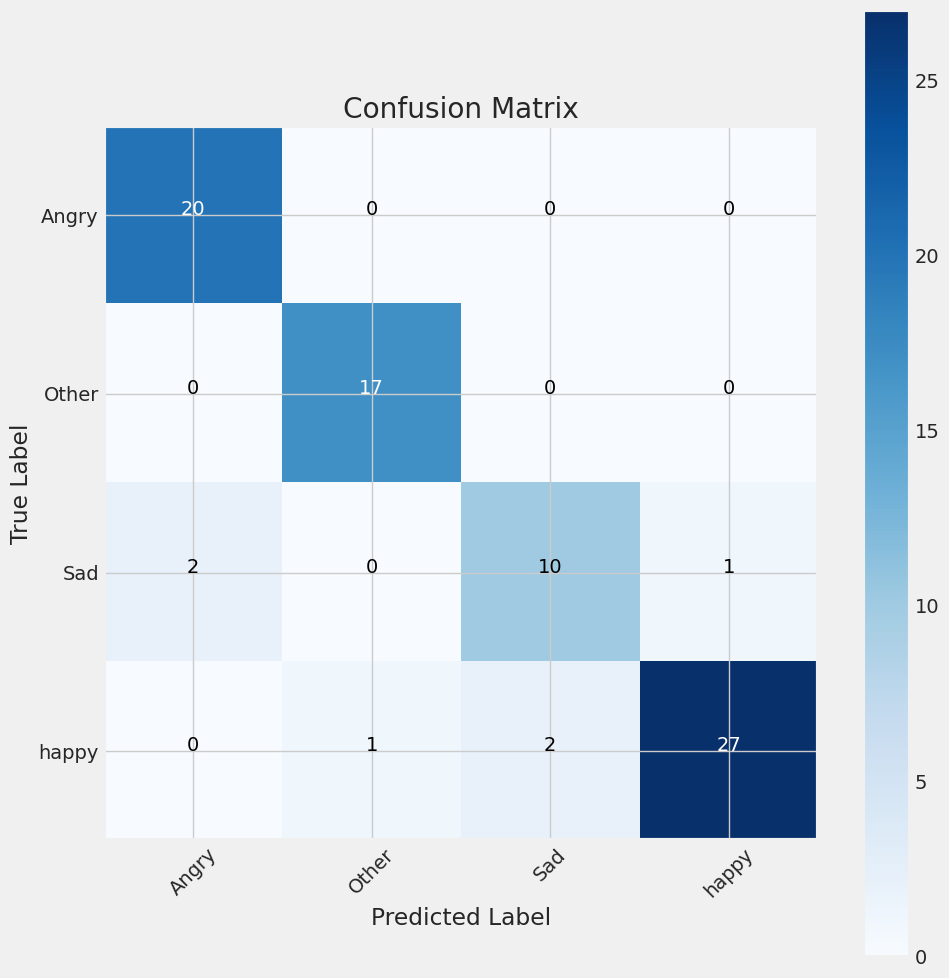

In [ ]:
# Confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       Angry       0.91      1.00      0.95        20
       Other       0.94      1.00      0.97        17
         Sad       0.83      0.77      0.80        13
       happy       0.96      0.90      0.93        30

    accuracy                           0.93        80
   macro avg       0.91      0.92      0.91        80
weighted avg       0.92      0.93      0.92        80



In [ ]:
model.save_weights('Pets_Facial_Expression_model.h5')

1/1 [==============================] - 4s 4s/step


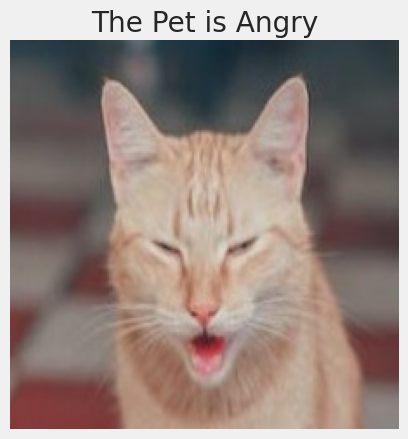

In [ ]:
#load the model and predict the inputs
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    class_indices = train_gen.class_indices
    class_labels = list(class_indices.keys())
    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    if predicted_class_label == 'Other':
        plt.title(f"The pet is normal")
    else:
        plt.title(f"The Pet is {predicted_class_label}")
    plt.show()

model.load_weights('/kaggle/working/Pets_Facial_Expression_model.h5')

class_labels = ['Angry', 'Other', 'Sad', 'Happy']

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = '/Users/unnathi/Downloads/Angry/02.jpg'
predict_and_display(image_path_to_test, model)

1/1 [==============================] - 0s 38ms/step


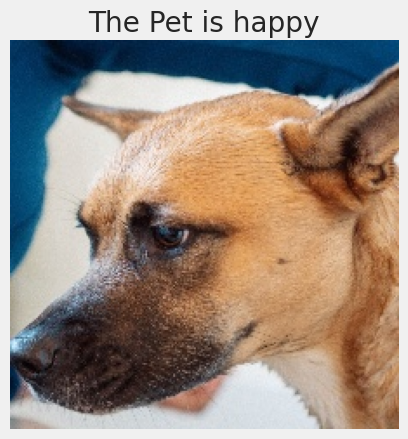

In [ ]:
image_path_to_test = '/Users/unnathi/Downloads/Master Folder/test/Sad/060.jpg'
predict_and_display(image_path_to_test, model)

1/1 [==============================] - 0s 39ms/step


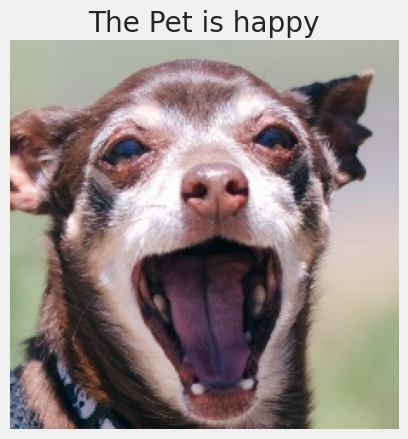

In [ ]:
image_path_to_test = '/Users/unnathi/Downloads/Master Folder/test/happy/038.jpg'
predict_and_display(image_path_to_test, model)

1/1 [==============================] - 0s 40ms/step


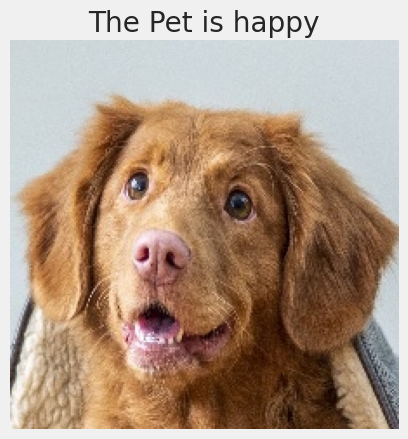

In [ ]:
image_path_to_test = '/Users/unnathi/Downloads/Master Folder/test/happy/100.jpg'
predict_and_display(image_path_to_test, model)

1/1 [==============================] - 0s 39ms/step


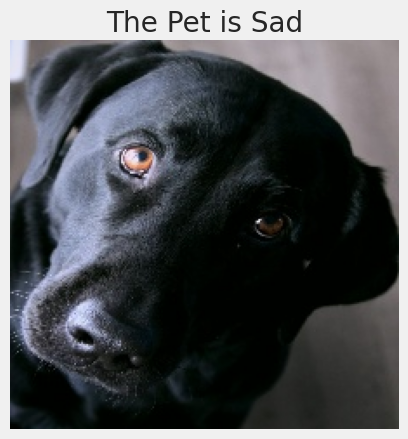

In [ ]:
image_path_to_test = '/Users/unnathi/Downloads/Master Folder/test/Other/47.jpg'
predict_and_display(image_path_to_test, model)